In [ ]:
%%capture
%pip install gurobipy
import warnings
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import Model
from gurobipy import GRB
warnings.filterwarnings('ignore')

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.25MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.78MB/s]



Training with SGD optimizer...
Epoch [1/100], Loss: 0.4177, Test Accuracy: 90.92%
Epoch [11/100], Loss: 0.2781, Test Accuracy: 92.42%
Epoch [21/100], Loss: 0.2671, Test Accuracy: 92.20%
Epoch [31/100], Loss: 0.2608, Test Accuracy: 90.94%
Epoch [41/100], Loss: 0.2563, Test Accuracy: 92.28%
Epoch [51/100], Loss: 0.2542, Test Accuracy: 92.50%
Epoch [61/100], Loss: 0.2527, Test Accuracy: 92.17%
Epoch [71/100], Loss: 0.2515, Test Accuracy: 92.31%
Epoch [81/100], Loss: 0.2470, Test Accuracy: 91.58%
Epoch [91/100], Loss: 0.2465, Test Accuracy: 92.29%
Epoch [100/100], Loss: 0.2460, Test Accuracy: 92.21%

Training with RMSprop optimizer...
Epoch [1/100], Loss: 1.4098, Test Accuracy: 89.72%
Epoch [11/100], Loss: 0.8400, Test Accuracy: 90.05%
Epoch [21/100], Loss: 0.8077, Test Accuracy: 90.92%
Epoch [31/100], Loss: 0.7966, Test Accuracy: 87.32%
Epoch [41/100], Loss: 0.7961, Test Accuracy: 87.24%
Epoch [51/100], Loss: 0.8000, Test Accuracy: 90.82%
Epoch [61/100], Loss: 0.7792, Test Accuracy: 88.2

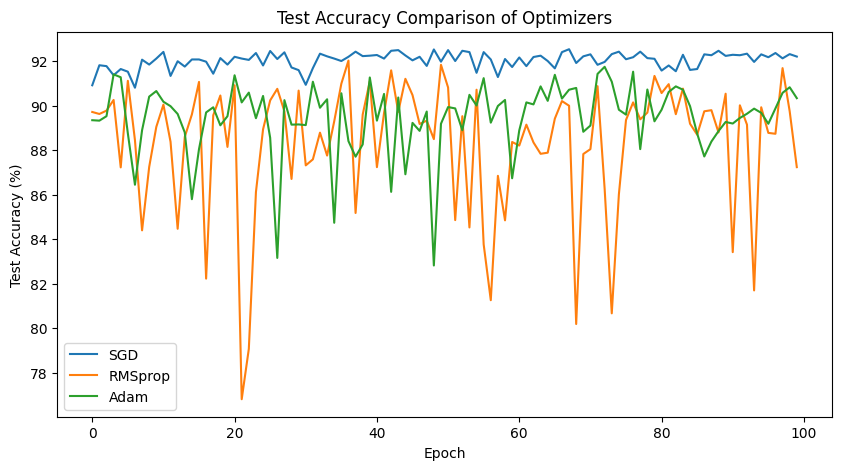

In [ ]:
# Making necessary imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Step 1: Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Load and Preprocess the MNIST Data
# Normalize pixel values to [-1, 1] and flatten images into 784-dim vectors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Fixed normalization
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders for mini-batch training
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Define the Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)  # CrossEntropyLoss will apply softmax

# Model parameters
input_size = 28 * 28  # 784 pixels per image
num_classes = 10  # Digits 0-9

# Step 4: Training Function
def train_model(optimizer_name, model, train_loader, test_loader, num_epochs=100, lr=0.01):
    model.to(device)
    criterion = nn.CrossEntropyLoss()  # Softmax applied internally

    # Choose optimizer based on input parameter
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=0.99)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    else:
        raise ValueError("Invalid optimizer name")

    train_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.view(-1, input_size).to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Step 5: Evaluate Model Performance
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.view(-1, input_size).to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

# Step 6: Train and Compare Different Optimizers
optimizers = ["SGD", "RMSprop", "Adam"]
results = {}

for opt in optimizers:
    print(f"\nTraining with {opt} optimizer...")
    model = LogisticRegression(input_size, num_classes)
    train_losses, test_accuracies = train_model(opt, model, train_loader, test_loader, num_epochs=100, lr=0.01)
    results[opt] = test_accuracies

# Step 7: Plot Results - Test Accuracy Over Epochs
plt.figure(figsize=(10, 5))
for opt in optimizers:
    plt.plot(results[opt], label=opt)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison of Optimizers")
plt.legend()
plt.show()